In [3]:
import scipy.io
import torch
from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

Data

In [ ]:
path_anesthesia = "data_ts_Anesthesia_Cleaned.mat"
data_anesthesia = scipy.io.loadmat(path_anesthesia)

In [ ]:
ts_aw = data_anesthesia["ts_aw"]
ts_keta = data_anesthesia["ts_keta"]
ts_lpp = data_anesthesia["ts_lpp"]
ts_dpp = data_anesthesia["ts_dpp"]
ts_selv2 = data_anesthesia["ts_selv2"]
ts_selv4 = data_anesthesia["ts_selv4"]

print(ts_aw.shape,   "\n",
      ts_selv2.shape,"\n",
      ts_selv4.shape,"\n",
      ts_lpp.shape,  "\n",
      ts_dpp.shape,  "\n",
      ts_keta.shape)

(1, 24) 
 (1, 18) 
 (1, 11) 
 (1, 21) 
 (1, 23) 
 (1, 22)


Preprocessing

In [ ]:
def preprocess(array):
    reshaped_data = np.stack(array[0], axis=0)
    reshaped_data = reshaped_data.transpose(0, 2, 1) # reshape to use nplets_measures (subjects x samples x regions)
    mean = np.mean(reshaped_data, axis=1, keepdims=True)
    std = np.std(reshaped_data, axis=1, keepdims=True)
    reshaped_normalized = (reshaped_data - mean) / std
    return reshaped_normalized


altered_states = {
    "ketamine": preprocess(ts_keta),
    "moderate_propofol": preprocess(ts_lpp),
    "deep_propofol": preprocess(ts_dpp),
    "ts_selv2": preprocess(ts_selv2),
    "ts_selv4": preprocess(ts_selv4),
}
all_states = {
    "awake": preprocess(ts_aw),
    "ketamine": preprocess(ts_keta),
    "moderate_propofol": preprocess(ts_lpp),
    "deep_propofol": preprocess(ts_dpp),
    "ts_selv2": preprocess(ts_selv2),
    "ts_selv4": preprocess(ts_selv4),
}

In [24]:
state_data[0].shape

(500, 82)

In [25]:
measures_list = []
for state_name, state_data in all_states.items():
    for subject in range(state_data.shape[0]):
        TC, DTC, O, S = nplets_measures(state_data[subject])[0][0]
        measures_list.append([state_name, subject, TC.item(), DTC.item(), O.item(), S.item()])
cols = ["state", "subject_n", "TC", "DTC", "O", "S"]
measures_df = pd.DataFrame(measures_list, columns=cols)
measures_df.head(10)

,state,subject_n,TC,DTC,O,S
0,awake,0,115.887471,65.911763,49.975708,181.799234
1,awake,1,121.996863,62.908807,59.088056,184.905669
2,awake,2,95.039838,48.757071,46.282767,143.796909
3,awake,3,86.208496,49.035985,37.172511,135.244480
4,awake,4,90.599527,49.350903,41.248624,139.950430
5,awake,5,119.378082,63.608017,55.770065,182.986099
6,awake,6,95.741530,49.927767,45.813763,145.669297
7,awake,7,99.711094,46.353770,53.357325,146.064864
8,awake,8,85.240422,42.367982,42.872440,127.608405
9,awake,9,103.307628,43.287609,60.020019,146.595237


Show results

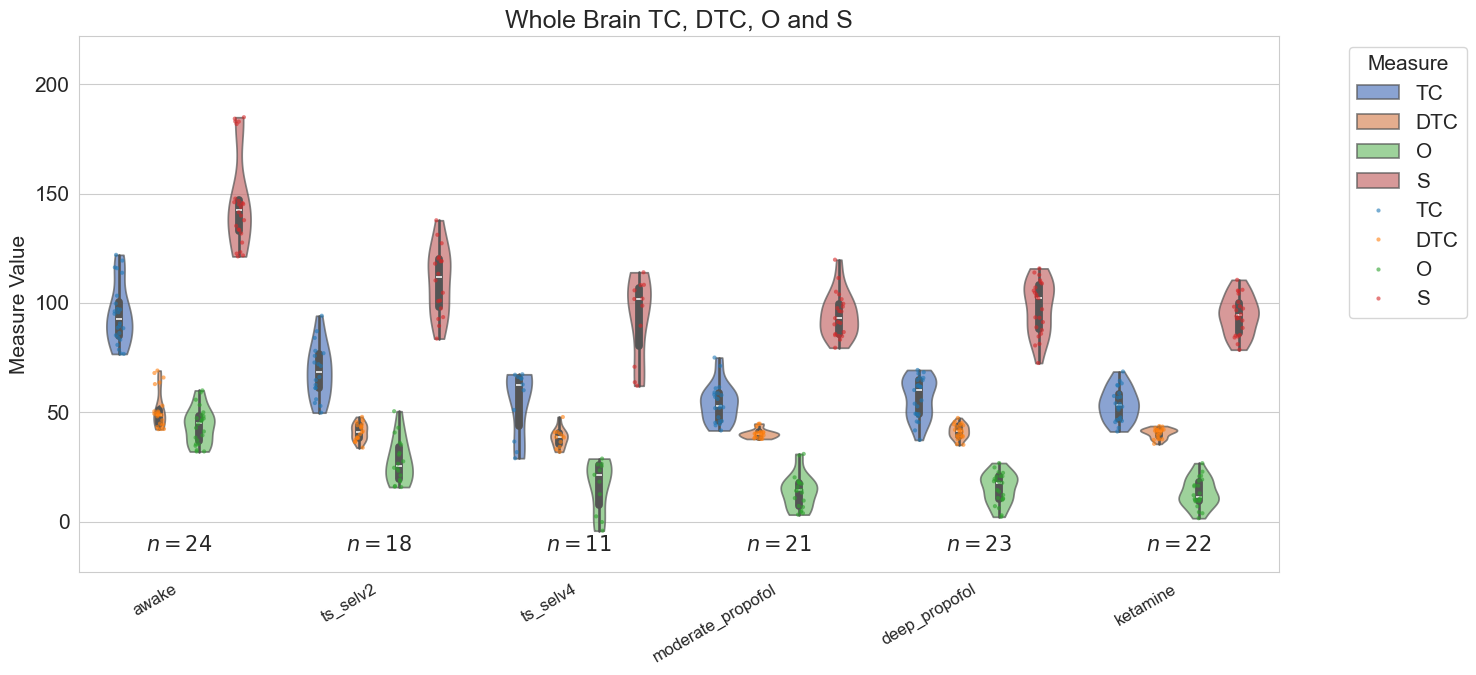

In [27]:
plt.rcParams.update({"font.size": 15})

# Melt DataFrame for plotting
df_melted = measures_df.melt(
    id_vars=["state", "subject_n"], var_name="Measure", value_name="Value"
)

custom_order = [
    "awake",
    "ts_selv2",
    "ts_selv4",
    "moderate_propofol",
    "deep_propofol",
    "ketamine",
]
# Initialize plot
plt.figure(figsize=(15, 7))
sns.set_style("whitegrid")

# Create violin + boxplot with individual markers
ax = sns.violinplot(
    data=df_melted,
    x="state",
    y="Value",
    hue="Measure",
    inner="box",
    palette="muted",
    dodge=True,
    alpha=0.7,
    cut=0,
    order=custom_order,
)

# # Overlay individual subject markers
strip = sns.stripplot(
    data=df_melted,
    x="state",
    y="Value",
    hue="Measure",
    dodge=True,
    jitter=True,
    alpha=0.6,
    size=3,
    order=custom_order,
)

# Annotate number of samples on top of each violin
y_max = df_melted["Value"].max()  # Adjust spacing for bars
y_min = df_melted["Value"].min()  # Adjust spacing for bars
bar_height = (y_max - y_min) * 0.1  # Vertical space between bars
# Annotate sample sizes
for i, state in enumerate(custom_order):
    n_samples = len(measures_df[measures_df["state"] == state])
    plt.text(
        i,
        y_min - bar_height * 0.5,
        rf"$n={n_samples}$",
        ha="center",
        fontweight="bold",
    )

# Beautify plot
plt.title(f"Whole Brain TC, DTC, O and S")
# plt.xlabel("State")
plt.xlabel("")
plt.ylabel("Measure Value")
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.ylim(y_min - bar_height, y_max * 1.2)
plt.legend(title="Measure", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()